# Evaluación Final - Curso "Analisis de datos interrelacionados" - 20200630


# LEER ATENTAMENTE LO SIGUIENTE ANTES DE EMPEZAR

# Consideraciones generales

*   El trabajo es extrictamente individual, toda consulta debe realizarse por el chat de Zoom al docente
*   Puede consultarse material de teórico y práctico
*   No se aceptan trabajos fuera de plazo


# 1. Ambiente COLAB remoto

1.   Abrir en navegador: https://colab.research.google.com/
2.   Abrir el notebook del examen:
     File-> Open Notebook -> Github -> https://github.com/prbocca/na101_master -> evaluations/ar_exam2020cpap.ipynb
3.   Guardar el notebook en su Google Drive:
     File -> Save a Copy in Drive... 
4.   Renombrar el archivo `"cedula ID"_ar_exam2020cpap.ipynb`, por ejemplo *33484022_ar_exam2020cpap.ipynb*
5.   Al final usted deberá descargar el notebook. Asegurarse que se están guardando las salidas de ejecución en el notebook: File -> Download .ipynb
6.   Luego estos archivos deberán ser enviados a prbocca@fing.edu.uy antes del tiempo máximo de entrega






## 1.a) Cargar Librerias

In [1]:
# cargar librerias
load_libs <- function(libraries = libs, install=TRUE){
  if (install){ # instalar librerias no instaladas
    new.packages <- libs[!(libs %in% installed.packages()[,"Package"])]
    if(length(new.packages)) install.packages(new.packages)
  }
  #cargo librerias  
  for (lib in libraries){
    require(lib, character.only=TRUE, quietly = FALSE)
  } 
} 

libs = c("ROCR", 
         "sand","igraph") #las basicas

load_libs(libs)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bitops’, ‘gtools’, ‘gdata’, ‘caTools’, ‘gplots’, ‘igraphdata’


Loading required package: ROCR

Loading required package: sand

Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: igraphdata


Statistical Analysis of Network Data with R, 2nd Edition
Type in C2 (+ENTER) to start with Chapter 2.



## 1.b) Descargar funciones auxiliares

In [2]:
#directorio donde se va a trabajar
data_path = "/content/ar/exam/"

dir.create(data_path, showWarnings = FALSE, recursive = TRUE)
setwd(data_path)
getwd()
list.files()

# cargo funciones auxiliares
source("https://raw.githubusercontent.com/prbocca/na101_master/master/homeworks_common.r")

[1] "/content/ar/exam"

character(0)

# 2. Cargar y explorar los datos

Trabajaremos con una red que representa las relaciones mutuas de amistad en secundaria. La red fue creada a partir de una simulación, y tiene $1461$ vértices (estudiantes) y $974$ aristas unidireccionales (amistad mutua). Los vértices tienen los siguientes atributos: Grade: el grado, de 7 a 12 años; Sex: (M)asculino o (F)emenino; y Race: la raza.

Los datos originales surgen de una encuesta en dos colegios secundarios de la misma comunidad. Se completaron los datos faltantes y se unieron las dos fuentes para construir una única red (llamada aquí red original). Por razones de confidencialidad, no se dispone de la red original, sino de una red simulada.
El proceso para generar la simulación fue: (i) mapear la red original, (ii) entrenar un ERGM que ajuste bien a los datos originales, (iii) usando el modelo entrenado, sortear una red simulada (con la que trabajaremos).

Fuente:
Resnick M.D., Bearman, P.S., Blum R.W. et al. (1997). Protecting adolescents from harm. Findings from the National Longitudinal Study on Adolescent Health, Journal of the American Medical Association, 278: 823-32.



## 2.a) Descargar los datos en formato GRAPHML de una red de amistades, y cargar los datos como un grafo (de igraph).

[1] "g_magnolia.graphml" "g_magnolia.zip"

IGRAPH 8b4b946 UN-- 1461 974 -- 
+ attr: Grade (v/n), na (v/l), Race (v/c), Sex (v/c), vertex.names
| (v/c), id (v/c), name (v/c), na (e/l)


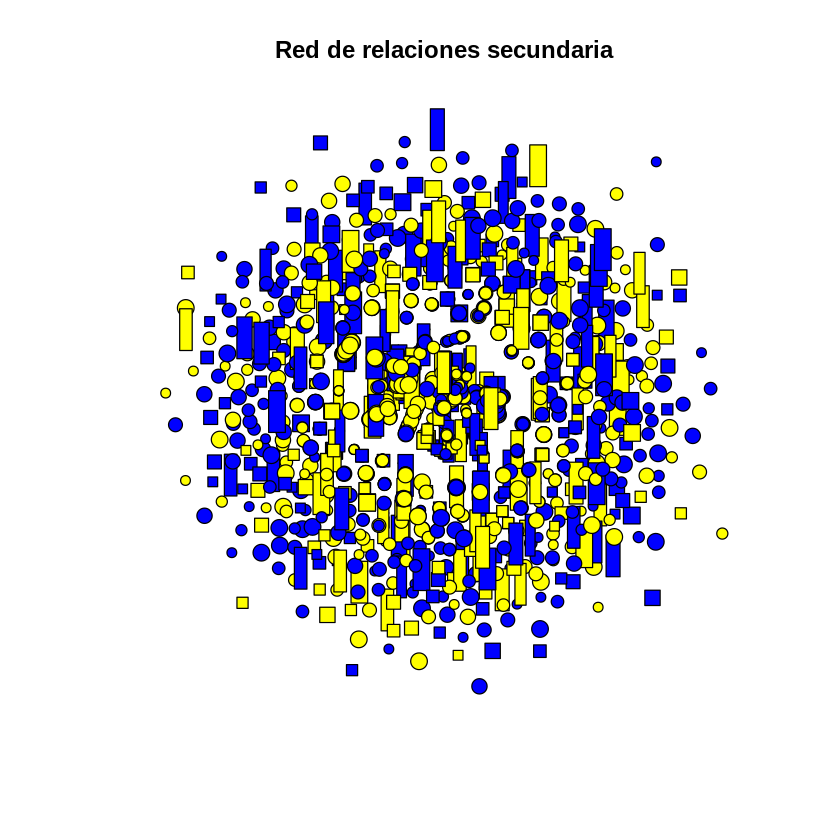

In [3]:
# download data
download.file(url="https://github.com/prbocca/na101_master/raw/master/evaluations/g_magnolia.zip", destfile="g_magnolia.zip", mode="wb")
unzip(zipfile="g_magnolia.zip")
list.files()

# cargar el grafo en la variable g
g = NA
##################################################################
#                       TU CÓDIGO ACÁ                           
# Tip: usar funcion de igraph
#
# para que funcione el link directo de google.. https://sites.google.com/site/gdocs2direct/
g = read.graph(file="g_magnolia.graphml", format= "graphml")
#
##################################################################
summary(g)

#dibujo el grafo
plot.amistad <- function(graph, title='Red de relaciones secundaria', graphpart=NULL, ...){
  set.seed(25)
  E(graph)$color = "black"
  l = layout_with_drl(graph)
  if (is.null(graphpart)){
    plot( graph, 
          layout=l, 
          vertex.shape = ifelse(factor(V(graph)$Race)=="White", 'circle', 
                                ifelse(factor(V(graph)$Race)=="Black", 'square', 'rectangle')),
          vertex.size=as.numeric(V(graph)$Grade)*0.5, 
          vertex.color=ifelse(factor(V(graph)$Sex)=="F", 'yellow', 'blue'),
          vertex.label=NA, 
          main=title,...)
  }else{
    plot( graphpart, graph, 
          layout=l, 
          vertex.shape = ifelse(factor(V(graph)$Race)=="White", 'circle', 
                                ifelse(factor(V(graph)$Race)=="Black", 'square', 'rectangle')),
          vertex.size=as.numeric(V(graph)$Grade)*0.5, 
          vertex.color=ifelse(factor(V(graph)$Sex)=="F", 'yellow', 'blue'),
          vertex.label=NA, 
          main=title,...)
  }
  
}
plot.amistad(g)

## 2.b) Quedarme con la componente gigante del grafo


Al finalizar, el resultado debería verse de acuerdo a la siguiente figura:

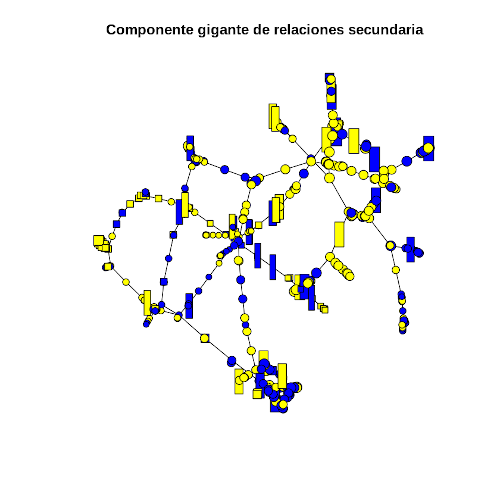


IGRAPH 3c50465 UN-- 439 573 -- 
+ attr: Grade (v/n), na (v/l), Race (v/c), Sex (v/c), vertex.names
| (v/c), id (v/c), name (v/c), na (e/l)


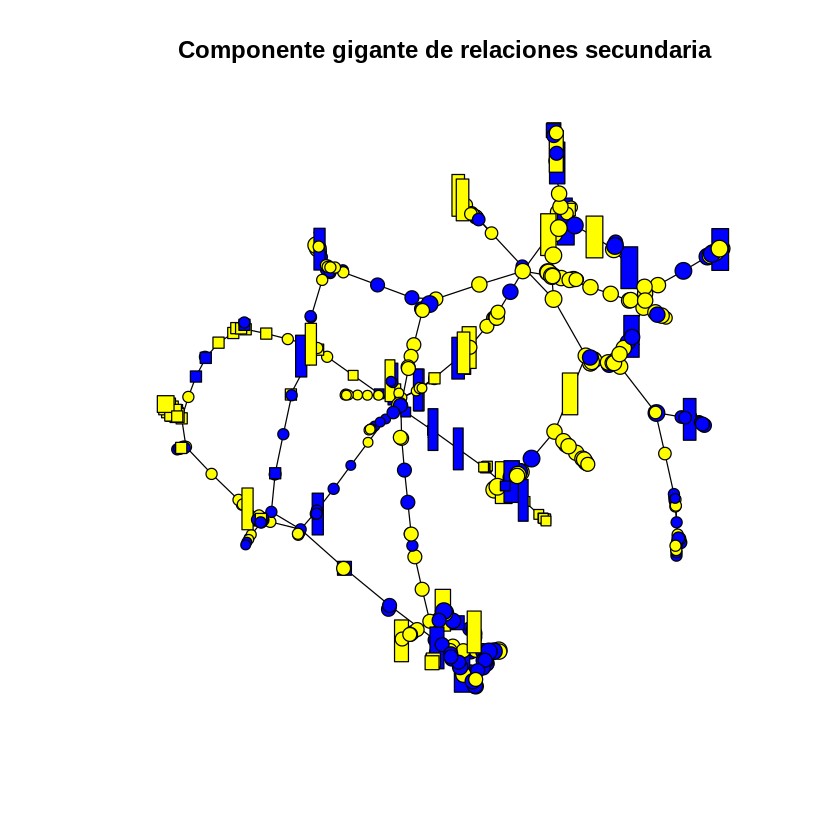

In [4]:
# # hacer la componente gigante
giant.component <- function(graph, ...) {
  cl <- clusters(graph, ...)
  induced_subgraph(graph, which(cl$membership == which.max(cl$csize)))
}


# cargar el grafo de la componente gigante en la variable gc
gc = NA
##################################################################
#                       TU CÓDIGO ACÁ                           
# Tip: usar funcion giant.component()
#
gc = giant.component(g)
#
##################################################################
summary(gc)

#dibujo el grafo
plot.amistad(gc, title="Componente gigante de relaciones secundaria")

## 2.c) Interpretar los datos

Responder a las siguientes preguntas sobre el grafo gc

In [5]:
##################################################################
#                       TU RESPUESTAS ACÁ                           
# 
# 2.c.1) ¿El grafo gc es dirigido?: NO
# 2.c.2) ¿Cuál es el tamaño del grafo gc?: 573
# 2.c.3) ¿Cuál es el orden del grafo gc?: 439
# 2.c.4) En el dibujo, ¿qué representa el color de los vértices?, ¿y qué representa la forma de los vértices?: color=sexo, forma=raza
#
##################################################################

## 2.d) Estudiantes con más y menos amigos en la componente gigante

Obtener la cantidad de estudiantes con menos amigos.

Obtener el nombre (atributo de vértice `name`) de los estudiantes con más amigos.

Además graficar el histograma de la distribución de grafo.

In [6]:
# estudiantes con menos amigos

printf("Los estudiantes con menos amigos tienen solo %s amigo.", min(degree(gc)))

cant_menosamigos = NA #cantidad de estudiantes con menos amigos
##################################################################
#                       TU CÓDIGO ACÁ   
#                        
cant_menosamigos = sum(degree(gc)==min(degree(gc)))
#111
#
#
##################################################################
printf("La cantidad de estudiantes que tienen menos amigos son: %s", cant_menosamigos) 

[1] "Los estudiantes con menos amigos tienen solo 1 amigo."
[1] "La cantidad de estudiantes que tienen menos amigos son: 111"


In [7]:
# estudiantes con mas amigos

name_masamigos = NA #vector de nombres de estudiantes con mas amigos
cant_masamigos = NA #cantidad de estudiantes con mas amigos
##################################################################
#                       TU CÓDIGO ACÁ   
#                        
cant_masamigos = sum(degree(gc)==max(degree(gc)))
#2
name_masamigos = V(g)$name[degree(g)==max(degree(gc))]
# n764, n990
#
##################################################################
printf("Los nombres de los estudiantes que tienen mas amigos son: %s", name_masamigos) 
printf("La cantidad de estudiantes que tienen mas amigos son: %s", cant_masamigos) 

[1] "Los nombres de los estudiantes que tienen mas amigos son: n764"
[2] "Los nombres de los estudiantes que tienen mas amigos son: n990"
[1] "La cantidad de estudiantes que tienen mas amigos son: 2"


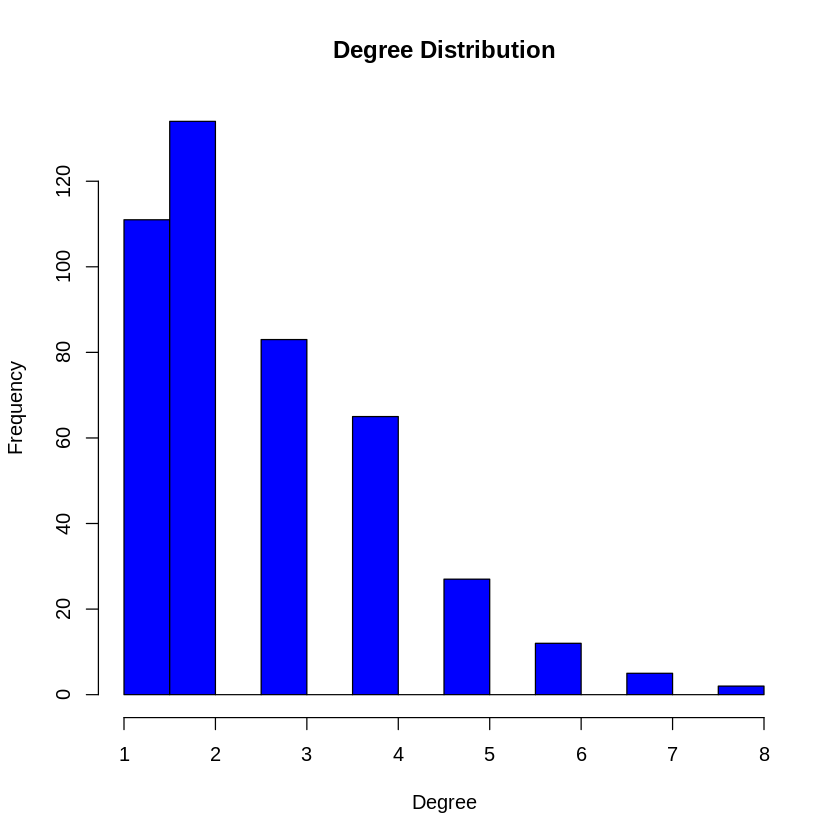

In [8]:
# histograma de distribución de grado

##################################################################
#                       TU CÓDIGO ACÁ   
#                        
hist(degree(gc),col="blue", xlab="Degree", ylab="Frequency", main="Degree Distribution")
#
#
##################################################################

##################################################################
#                       TU RESPUESTAS ACÁ                           
# 
# 2.d.1) Viendo el histograma, ¿Cuál es la cantidad de amigos más frecuente entre estudiantes?: 2
#
##################################################################

## 2.e) Responder algunas preguntas teóricas relacionadas a este tema


In [9]:
##################################################################
#                       TU RESPUESTAS ACÁ                           
# 
# 2.e.1) ¿Cuáles son las 4 categorías generales en las que se clasifican las redes reales?: tecnológicas, sociales, de información, biológicas
# 2.e.2) ¿Qué es el 'orden' de un grafo?: cantidad de vértices
# 2.e.3) ¿Las redes reales son típicamente densas o dispersas?: dispersas
# 2.e.4) ¿Qué es la componente gigante de una red?: la componente conexa más grande del grafo que crece en orden linealmenet con la cantidad de vértices
# 2.e.5) ¿Típicamente los hipergrafos se representan como un grafo de qué tipo?: bipartito
#
##################################################################

# 3. Centralidad de vértices

Estudiar cuales son los estudiantes más importantes en el grafo gc...

Utilizando el paquete `igraph` calcular las métricas de centralidad: `degree(), closeness(), betweenness(), evcent(), page.rank()`, 
y comparar los tres usuarios con mayor centralidad para cada una de ellas.


## 3.a) Obtener las centralidades de los tres estudiantes más importantes

In [10]:
# calcular centralidades y imprimir los 3 estudiantes más importantes para cada una de ellas
##################################################################
#                       TU CÓDIGO ACÁ                           
#
#
n = 3 
d = degree(gc) 
head(d[order(d,decreasing = T)],n) #imprime los 3 usuarios más relevantes

cl = closeness(gc)
head(cl[order(cl,decreasing = T)],n)

bw = betweenness(gc)
head(bw[order(bw,decreasing = T)],n)

ev = evcent(gc)$vector #Eigenvector Centrality
head(ev[order(ev,decreasing = T)],n)

pr = page.rank(gc)$vector 
head(pr[order(pr,decreasing = T)],n)
#
##################################################################

n764 n990 n121 
   8    8    7

n768        n1390         n129 
0.0001970832 0.0001963479 0.0001959248

n759      n62    n1220 
49459.67 46176.57 34419.97

n121     n1159     n1142 
1.0000000 0.9224898 0.9222141

n764       n1390       n1225 
0.005423682 0.004918050 0.004877164

## 3.b) Responder algunas preguntas teóricas relacionadas a este tema

In [11]:
##################################################################
#                       TU RESPUESTAS ACÁ                           
# 
# 3.b.1) Si la ponderación de un grafo presenta errores de medida, ¿cuál es la centralidad que esperamos más se afecte por esos errores?: intermediación
# 3.b.2) ¿Qué problema resuelve la centralidad Page-Rank si la comparamos con la centralidad de vector propio?: Es robusta al que el grafo no sea fuertemente conexo/ conexo
# 3.b.3) ¿Cuál es el nombre (o la sigla) de la centralidad que ofrece un valor de autoridad y otro de hub?: HITS
#
##################################################################

# 4. Detección de comunidades

Buscaremos particionar el grafo gc de acuerdo a su estructura, es decir detectaremos sus comunidades.

## 4.a) Particionado goloso

Realizar el particionado goloso rápido (clustering jerárquico aglomerativo) en varias comunidades usando funciones de `igraph`.


[1] "Se encontraron 21 comunidades"
[1] "La mayoría de las comunidades son muy pequeñas:"


Community sizes
 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 
24 28 34 24 28 42 24 25 21 21 19 16 17 16 20 12 15 22 11 11  9 

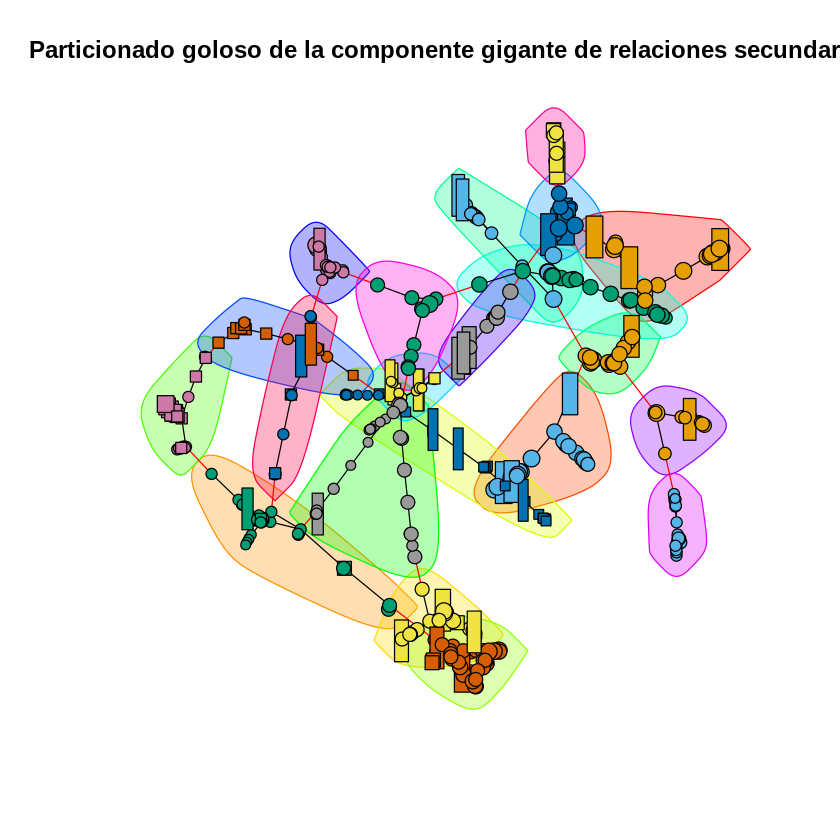

In [12]:
#  realizar el particionado golozo
set.seed(10)

gc.fg = NA #resultado del particionado
##################################################################
#                       TU CÓDIGO ACÁ                           
#
#
gc.fg <- fastgreedy.community(gc, merges=T)
#
#
##################################################################
printf("Se encontraron %s comunidades", length(gc.fg))
printf("La mayoría de las comunidades son muy pequeñas:")
sizes(gc.fg)

#dibujo el grafo
plot.amistad(gc, "Particionado goloso de la componente gigante de relaciones secundaria", gc.fg)

Dado que el metodo de particionado es jerárquico es posible definir la cantidad de comunidades que se quiere. Utilizando el cálculo anterior, particionar solo en dos comunidades. El resultado debería ser el de la figura:

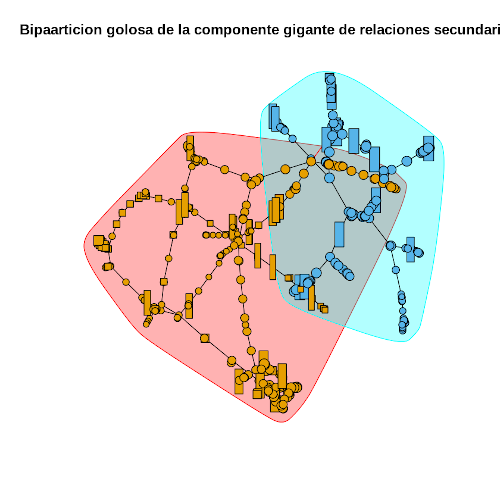

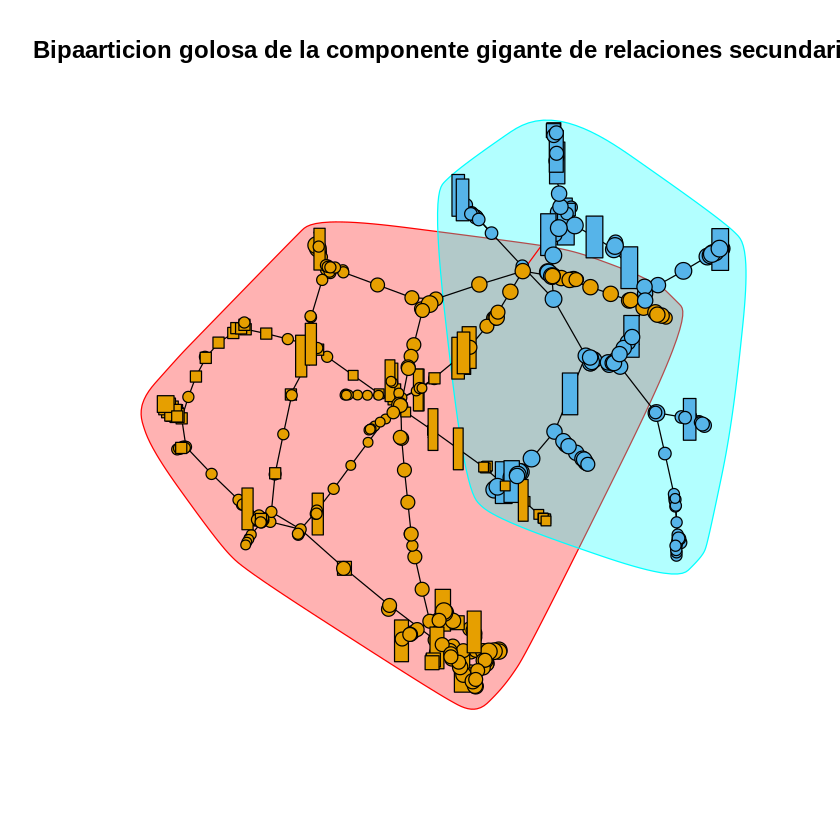

In [13]:
# utilizando el particionado golozo anterior, creamos una estructura de membership cortando el dendograma en 2 comunidades
gc.fg2 = structure(list(membership=cutat(gc.fg, 2)), class="communities")

plot.amistad(gc, "Bipaarticion golosa de la componente gigante de relaciones secundaria", gc.fg2)

## 4.b) Particionado espectral

Realizar el particionado espectral (maximización espectral de modularidad) en varias comunidades usando funciones del igraph.

[1] "Se encontraron 26 comunidades"
[1] "La mayoría de las comunidades son muy pequeñas:"


Community sizes
 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 
40 25 38 24 19  5 24 13 33 21 16  8 16 14 13  4  5  2  2 19 27 16 17 13 12 13 

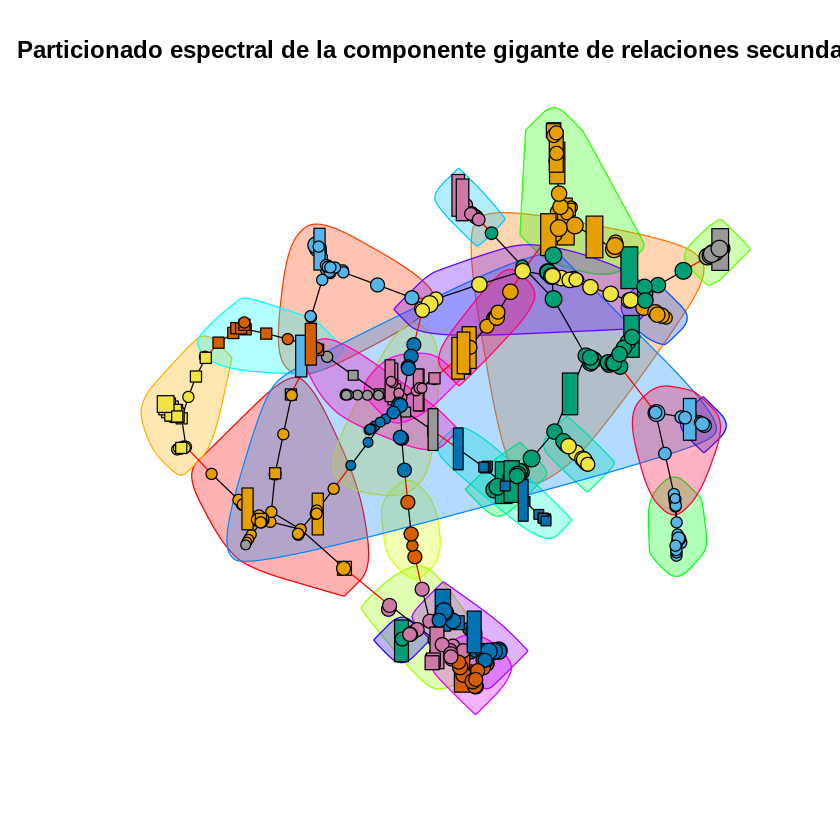

In [14]:
#  realizar el particionado espectral
set.seed(10)

gc.part = NA #resultado del particionado
##################################################################
#                       TU CÓDIGO ACÁ                           
#
#
gc.part = leading.eigenvector.community(gc)
#
#
##################################################################
printf("Se encontraron %s comunidades", length(gc.part))
printf("La mayoría de las comunidades son muy pequeñas:")
sizes(gc.part)

#dibujo el grafo
plot.amistad(gc, "Particionado espectral de la componente gigante de relaciones secundaria", gc.part)

Utilizando el cálculo anterior, intentar particionar solo en dos comunidades. 

Warning message in cutat(gc.part, 5):
“Cannot have that few communities”


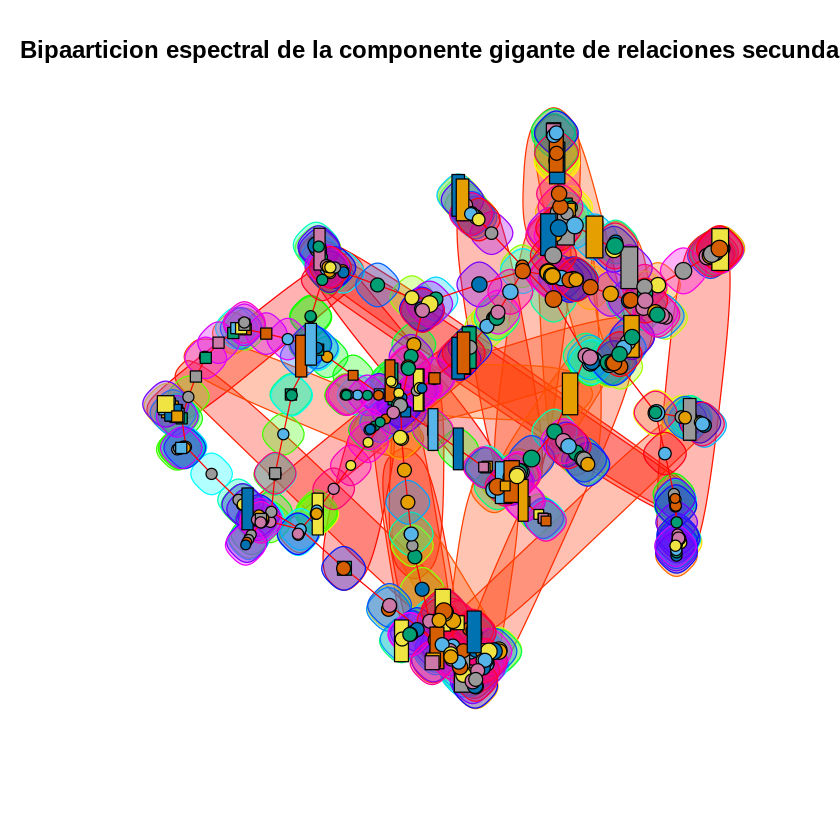

In [15]:
# utilizando el particionado golozo anterior

gc.part2 = NA #resultado del particionado en solo dos componentes
##################################################################
#                       TU CÓDIGO ACÁ                           
#
#
gc.part2 = structure(list(membership=cutat(gc.part, 5)), class="communities")
#
#
##################################################################

##################################################################
#                       TU RESPUESTA ACÁ                           
#
#
# 4.b.1) ¿Es posible particionar en solo dos comunidades usando esta función de particionado espectral? No
# 4.b.2) Si lo anterior no funciona, pero igual requiere particionar en dos comunidades de acuerdo a modularidad, ¿qué haría? Haaría el cálculo usando matrices según visto en el teórico
#
#
##################################################################

plot.amistad(gc, "Bipaarticion espectral de la componente gigante de relaciones secundaria", gc.part2)

## 4.c) Responder algunas preguntas teóricas relacionadas a este tema

In [16]:
##################################################################
#                       TU RESPUESTAS ACÁ                           
# 
# 4.c.1) Existen muchas definicions para subgrupo cohesivo en un grafo, la mayoría se basan en relajar el concepto de:... clique
# 4.c.2) Si en una red social tenemos una ponderación de fortaleza en las aristas, esperamos encontrar los vínculos débiles en las aristas puente?: Si
# 4.c.3) El particionado espectral se basa en maximizar la:... modularidad
#
##################################################################

# 5. Predicción de información faltante en una subred de la componente gigante

Estudiaremos que tan predictiva es la información de red. 
Primero estudiaremos la homofilia y mezcla selectiva en la red, y luego estudiaremos la predicción de enlaces y la predicción de atributos de vértices.

## 5.a) Homofilia y mezcla selectiva

In [17]:
# funcion que acumula los atributos de los vertices incientes a todas las aristas
mezcla.selectiva <- function(graph, attr) {
  # matriz de confusion segun sexo
  v = factor(vertex_attr(graph, attr))
  attr_uniques = sort(unique(v))
  cm = matrix(0, nrow=length(attr_uniques), ncol=length(attr_uniques),
              dimnames = list(attr_uniques,attr_uniques))
  el = as_edgelist(graph, name = FALSE)
  for (idx in 1:dim(el)[1]) {
    cm[sort(v[el[idx,]])[1], sort(v[el[idx,]])[2]] = cm[sort(v[el[idx,]])[1], sort(v[el[idx,]])[2]]+1
  }
  return(cm)
}
ms.Sex = mezcla.selectiva(gc, "Sex")

printf("La mezcla selectiva según Sex es:")
ms.Sex

ms.Grade = NA
ms.Race = NA
##################################################################
#                       TU CÓDIGO ACÁ                           
#
#
ms.Grade = mezcla.selectiva(gc, "Grade")
ms.Race = mezcla.selectiva(gc, "Race")
#
#
##################################################################
printf("La mezcla selectiva según Grade es:")
ms.Grade
printf("La mezcla selectiva según Race es:")
ms.Race

##################################################################
#                       TU RESPUESTA ACÁ                           
#
#
# 5.a.1) Opinión: ¿qué variable parece mostrar más homofilia positiva?
# La raza parece ser la de menor homofilia, la mayoria de las razas se mezclan más con White
# El sexo tiene mala homofilia, ambos generos tienen cierta preferencia por mezclarse con mujeres
# El grado es entonces donde hay una más marcada homofilia positiva a coincidir en la edad
#
#
##################################################################

[1] "La mezcla selectiva según Sex es:"


,F,M
F,238,189
M,0,146


[1] "La mezcla selectiva según Grade es:"


,7,8,9,10,11,12
7,66,9,2,1,0,0
8,0,145,5,5,0,2
9,0,0,40,11,3,4
10,0,0,0,100,21,3
11,0,0,0,0,87,18
12,0,0,0,0,0,51


[1] "La mezcla selectiva según Race es:"


,Asian,Black,Hisp,NatAm,Other,White
Asian,6,1,0,0,0,27
Black,0,38,6,0,0,33
Hisp,0,0,0,0,0,23
NatAm,0,0,0,2,0,16
Other,0,0,0,0,0,4
White,0,0,0,0,0,417


$\def\ccalN{{\mathcal N}}$

## 5.b) Predicción de aristas en la componente gigante de la red de amistad


En esta sección veremos que tan bien funcionan los métodos informales de *score* para predecir enlaces en la red `gc`.

Como vimos, los métodos informales de predicción de enlaces basados en *score* definen una medida de enlace para todo par de vértices que no son aristas (es decir, definen el *score*, $s(i,j)$, para todo $(i,j) \notin E^{obs}$), y predicen las aristas faltantes como aquellas parejas con mayor `score`.
Hay muchas funciones de `score` posibles, en este sección usaremos los   vecinos en común: $s(i,j)=|\ccalN_i^{obs}\cap \ccalN_j^{obs}|$.

Para medir la calidad de predicción de cada método usaremos la métrica $AUC$ (*Area Under Curve*). Un predictor aleatorio tiene $AUC=0.5$ y un predictor perfecto tiene $AUC=1.0$ por tanto los métodos serán mejores a mayor valor de $AUC$.

Utilizando la métrica AUC, evaluar la capacidad predictiva del método de *score* de vecinos en común, sobre una única subred observada con el $\%80$ de las aristas de la red `gc`.

Se disponen de varias funciones auxiliares precargadas, incluyendo `score()` y  `delete_edges_rand()`. Es posible ver las funciones axiliares en: https://raw.githubusercontent.com/prbocca/na101_master/master/homeworks_common.r.


OBSERVACIÓN: Se recomienda recordar lo realizado en el práctico relacionado. 

OBSERVACIÓN: No se requiere hacer un estudio exahustivo, solo evaluar el resultado para la red observada `gc_obs` del siguiente código.




In [18]:
#creo una subred observada sobre la que voy a predecir los enlaces no observados
set.seed(42)
gc_obs = delete_edges_rand(gc, p=0.2)

<sparse>[ <logic> ] : .M.sub.i.logical() maybe inefficient

<sparse>[ <logic> ] : .M.sub.i.logical() maybe inefficient



[1] "2020-07-02 14:46:21 init scoring common neighbors"
[1] "El método de score usando vecinos en cumún, tiene un AUC=0.673018604394074"


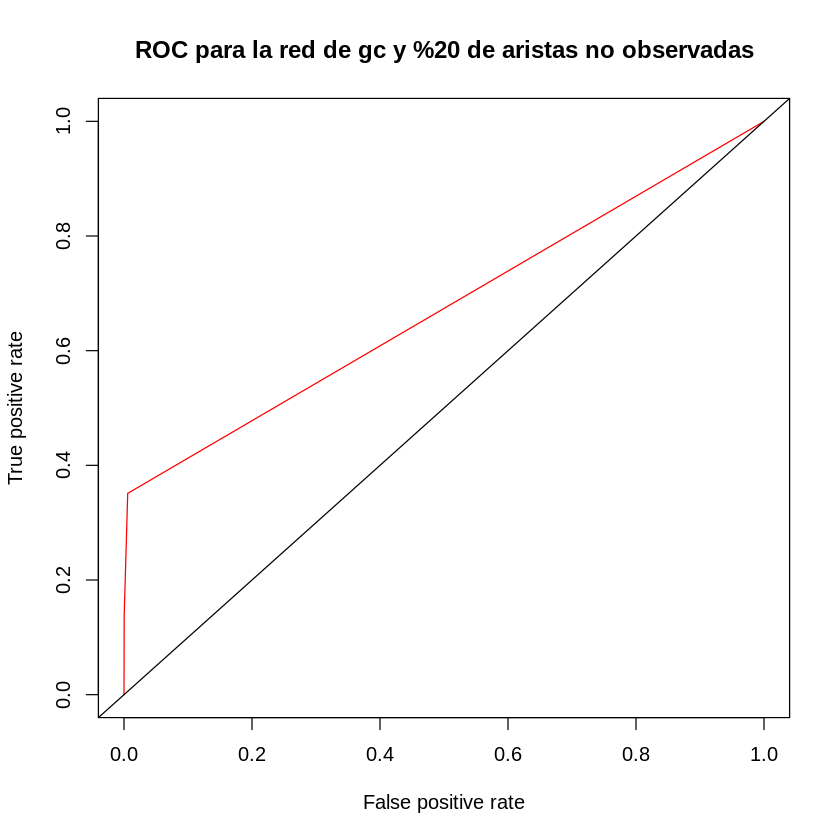

In [19]:
# calcular el AUC del método score(gc_obs, type="common neighbors")

true_possibleedges_no_obs = NA #vector real de aristas existentes no observadas
pred_possibleedges_no_obs = NA #vector predicho sobre las aristas no observadas 
##################################################################
#                       TU CÓDIGO ACÁ                           
#
#
# computo las aristas reales y las pongo en un vector (triangular inferior, mismo orden que score())
A_gc <- get.adjacency(gc)
A_gc_v <- A_gc[lower.tri(A_gc)]

# computo las aristas observadas y las pongo en un vector (triangular inferior, mismo orden que score())
A_gc_obs = get.adjacency(gc_obs)
A_gc_obs_v <- A_gc_obs[lower.tri(A_gc_obs)]
true_possibleedges_no_obs = A_gc_v[A_gc_obs_v==0] #vector real sobre aristas no observadas

# computo aristas predichas 
s_cn  = score(gc_obs, type="common neighbors")
pred_possibleedges_no_obs = s_cn$score[A_gc_obs_v==0] #vector predicho sobre aristas no observadas
#
#
##################################################################

# computo la performance
pred_gc <- prediction(pred_possibleedges_no_obs, true_possibleedges_no_obs)
perf_gc <- performance(pred_gc, "auc")
printf("El método de score usando vecinos en cumún, tiene un AUC=%s", slot(perf_gc, "y.values"))

#plot de la curva ROC
roc_gc = performance(pred_gc, measure = "tpr", x.measure = "fpr")
plot(roc_gc, col="red")
title("ROC para la red de gc y %20 de aristas no observadas")
abline(a=0, b=1)


##################################################################
#                       TU RESPUESTA ACÁ                           
#
#
# 5.b.1) ¿Qué AUC obtengo en este caso?: 0.673018604394074
#
#
##################################################################


## 5.c) Predicción de atributos de vértices en la componente gigante de la red de amistad

Un método sencillo para predecir los atributos faltantes es el método de los vecinos más cercanos (*NNM - nearest-neighbor method*), donde se estima el atributo faltante en el vértice $i$ como el promedio de los atributos en el vecindario de $i$. La idea de vecindario y promedio puede variar dependiendo del caso particular. Este método suele funcionar bien cuando existe una marcada homofilia entre los vértices participantes respecto a ese atributo.


Aquí evaluaremos la precisión del método NNM, sobre una subred observada con el $\%80$ de los atributos de vértice `Sex` de la red `gc`.
El atributo `Sex`, disponible en la red, es una variable categórica. Por tal motivo, el promedio sobre los vecinos del método NNM se define como el enumerado de mayor frecuencia. 
Para medir la calidad de predicción del método usaremos la exactitud  (*accuracy* - fracción de predicciones correctas).


Se disponen de varias funciones auxiliares, incluyendo `nnm()` y `delete_vertex_attr_rand()`. 
Es posible ver las funciones axiliares en: https://github.com/prbocca/na101_master/raw/master/homeworks_common.r.

OBSERVACIÓN: Se recomienda recordar lo realizado en el práctico relacionado. 

OBSERVACIÓN: No se requiere hacer un estudio exahustivo, solo evaluar el resultado para la red observada `gc_obs` del siguiente código.



In [20]:
#creo una subred observada sobre la que voy a predecir los atributos no observados
set.seed(43)
gc_obs = delete_vertex_attr_rand(gc,"Sex", p=0.2) #introduce NA en los atributos borrados

In [21]:
vertex_attr_actual = NA #vector real de atributos de vertices no observadas
vertex_attr_pred = NA #vector predicho de atributos de vertices no observadas 
##################################################################
#                       TU CÓDIGO ACÁ                           
#
#
vertex_attr_deleted = is.na(vertex_attr(gc_obs, "Sex")) #vector booleando con los atributos borrados

#computo vector con los atributos reales
vertex_attr_actual = vertex_attr(gc, "Sex")[vertex_attr_deleted] #vector con los atributos reales
vertex_attr_actual = factor(vertex_attr_actual, levels=sort(unique(vertex_attr(gc, "Sex"))))

#computo vector con atributos predichos
vertex_attr_pred  = nnm(gc_obs,"Sex", fun="freq")[vertex_attr_deleted] #vector con los atributos predichos
vertex_attr_pred = factor(vertex_attr_pred, levels=sort(unique(vertex_attr(gc, "Sex"))))
#
#
##################################################################

# computo la exactitud
cm = as.matrix(table(pred=vertex_attr_pred, actual=vertex_attr_actual)) # create the confusion matrix
accuracy = sum(diag(cm)) / sum(cm)
printf("La exactitud de NNM para predecir el atributo Sex en la red es %s", accuracy) 
cm


##################################################################
#                       TU RESPUESTA ACÁ                           
#
#
# 5.c.1) ¿Qué se puede concluir sobre la homofilia de 'Sex' en esta red de amistad? Hay un poco de homofilia, lo que concuerda con los observado en 5.a)
#
#
##################################################################


[1] "La exactitud de NNM para predecir el atributo Sex en la red es 0.588235294117647"


    actual
pred  F  M
   F 33 21
   M 14 17

Repetir la parte anterior para los atributos `Grade` y `Race`.


In [22]:
# predecir atributo Grade

#creo una subred observada
set.seed(42)
gc_obs = delete_vertex_attr_rand(gc,"Grade", p=0.2)
vertex_attr_deleted = is.na(vertex_attr(gc_obs, "Grade")) #vector booleando con los atributos borrados

vertex_attr_actual = NA #vector real de atributos de vertices no observadas
vertex_attr_pred = NA #vector predicho de atributos de vertices no observadas 
##################################################################
#                       TU CÓDIGO ACÁ                           
#
#
#computo vector con los atributos reales
vertex_attr_actual = vertex_attr(gc, "Grade")[vertex_attr_deleted] #vector con los atributos reales
vertex_attr_actual = factor(vertex_attr_actual, levels=sort(unique(vertex_attr(gc, "Grade"))))

#computo vector con atributos predichos
vertex_attr_pred  = nnm(gc_obs,"Grade", fun="freq")[vertex_attr_deleted] #vector con los atributos predichos
vertex_attr_pred = factor(vertex_attr_pred, levels=sort(unique(vertex_attr(gc, "Grade"))))
#
#
##################################################################

# computo la exactitud
cm = as.matrix(table(pred=vertex_attr_pred, actual=vertex_attr_actual)) # create the confusion matrix
accuracy = sum(diag(cm)) / sum(cm)
printf("La exactitud de NNM para predecir el atributo Grade en la red es %s", accuracy)  
cm

[1] "La exactitud de NNM para predecir el atributo Grade en la red es 0.266666666666667"


    actual
pred 7 8 9 10 11 12
  7  2 2 0  1  1  0
  8  4 7 2  3  1  2
  9  4 1 1  2  2  3
  10 3 8 2  6  1  2
  11 4 5 1  1  6  2
  12 1 2 2  1  3  2

In [23]:
# predecir atributo Race

#creo una subred observada
set.seed(42)
gc_obs = delete_vertex_attr_rand(gc,"Race", p=0.2)
vertex_attr_deleted = is.na(vertex_attr(gc_obs, "Race")) #vector booleando con los atributos borrados

vertex_attr_actual = NA #vector real de atributos de vertices no observadas
vertex_attr_pred = NA #vector predicho de atributos de vertices no observadas 
##################################################################
#                       TU CÓDIGO ACÁ                           
#
#
#computo vector con los atributos reales
vertex_attr_actual = vertex_attr(gc, "Race")[vertex_attr_deleted] #vector con los atributos reales
vertex_attr_actual = factor(vertex_attr_actual, levels=sort(unique(vertex_attr(gc, "Race"))))

#computo vector con atributos predichos
vertex_attr_pred  = nnm(gc_obs,"Race", fun="freq")[vertex_attr_deleted] #vector con los atributos predichos
vertex_attr_pred = factor(vertex_attr_pred, levels=sort(unique(vertex_attr(gc, "Race"))))
#
#
##################################################################

# computo la exactitud
cm = as.matrix(table(pred=vertex_attr_pred, actual=vertex_attr_actual)) # create the confusion matrix
accuracy = sum(diag(cm)) / sum(cm)
printf("La exactitud de NNM para predecir el atributo Race en la red es %s", accuracy)  
cm

[1] "La exactitud de NNM para predecir el atributo Race en la red es 0.544444444444444"


       actual
pred    Asian Black Hisp NatAm Other White
  Asian     0     0    0     0     0     6
  Black     0     2    1     0     0     9
  Hisp      0     0    0     1     0     4
  NatAm     0     0    0     0     0     2
  Other     0     0    0     0     0     2
  White     1    12    3     0     0    47

In [24]:
##################################################################
#                       TU RESPUESTA ACÁ                           
#
#
# 5.c.2) Pregunta sin respuesta obvia: ¿Porqué funciona tan mal para predicir el atributo Grade? 
# Es una variable categorica con muchos valores y muy desbalanceados, y por tanto es más facil equivocarse en la predicción.
# Usar frecuencia solo considera los amigos de exactamente la misma edad, pero si se observa la matriz de mezcla selectiva tambien hay amigos en las paralelas a la diagonal
# Si usamos la agregación "mean" se considerarian estas paralelas y mejora la prediccion notablemente:
#
set.seed(42)
gc_obs = delete_vertex_attr_rand(gc,"Grade", p=0.2)
vertex_attr_deleted = is.na(vertex_attr(gc_obs, "Grade")) #vector booleando con los atributos borrados

vertex_attr_actual = vertex_attr(gc, "Grade")[vertex_attr_deleted] #vector con los atributos reales
vertex_attr_actual = factor(vertex_attr_actual, levels=sort(unique(vertex_attr(gc, "Grade"))))

vertex_attr_pred2  = nnm(gc_obs,"Grade", fun="mean")[vertex_attr_deleted] #vector con los atributos predichos
vertex_attr_pred2 = factor(vertex_attr_pred2, levels=sort(unique(vertex_attr(gc, "Grade"))))
# computo la exactitud
cm2 = as.matrix(table(pred=vertex_attr_pred2, actual=vertex_attr_actual)) # create the confusion matrix
accuracy2 = sum(diag(cm2)) / sum(cm2)
printf("La exactitud de NNM para predecir el atributo Grade con MEAN en la red es %s", accuracy2)  
cm2

#
##################################################################

[1] "La exactitud de NNM para predecir el atributo Grade con MEAN en la red es 0.923076923076923"


    actual
pred  7  8  9 10 11 12
  7  14  1  0  0  0  0
  8   0 20  0  0  0  0
  9   1  0  6  0  0  0
  10  0  0  0 12  0  0
  11  0  0  1  1  9  1
  12  0  0  0  0  1 11

## 5.d) Responder algunas preguntas teóricas relacionadas a este tema

In [25]:
##################################################################
#                       TU RESPUESTA ACÁ                           
#
#
# 5.d.1) Típicamente las distribuciones de grado de las redes reales siguen una distribución:.... de potencias
# 5.d.2) ¿Qué conviene graficar para ver la distribución de grado de una gran red real: el histograma o la CCDF?: CCDF
# 5.d.3) ¿Los modelos de crecimiento de redes intentan imitar algún fenomo que sucede en las redes. Nombre dos de estos fenomenos:... popularidad y copia
#
#
##################################################################